# AnnNet Introduction - Multilayer Network Analysis in Systems Biology

In [2]:
# . Setup & Initialization

import numpy as np
import pandas as pd
from scipy.sparse.linalg import eigsh
from collections import defaultdict

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph

# visualization
import matplotlib.pyplot as plt

In [3]:
# . Initialize Graph with Full Configuration

G = Graph(directed=None, n=100, e=300)  # None = mixed directionality allowed

# Enable mutation history
G.enable_history(True)
G.mark("initialization")

# Set graph-level attributes (unstructured metadata)
G.graph_attributes["name"] = "Multi-Omic Disease Network"
G.graph_attributes["organism"] = "Homo sapiens"
G.graph_attributes["disease_context"] = "inflammatory_pathway"
G.graph_attributes["version"] = "1.0"

print(f"Graph initialized: capacity={G._matrix.shape}, history={G._history_enabled}")
print(f"Graph attributes: {G.graph_attributes}")


Graph initialized: capacity=(100, 300), history=True
Graph attributes: {'name': 'Multi-Omic Disease Network', 'organism': 'Homo sapiens', 'disease_context': 'inflammatory_pathway', 'version': '1.0'}


In [4]:
# . Define Multilayer Structure (Kivelä Formalism)

# Define multi-aspect structure
G.set_aspects(
    aspects=["omic"],
    elem_layers={
        "omic": ["PPI", "metabolic", "regulatory", "phenotype"]
    }
)

# Set aspect-level metadata
G.set_aspect_attrs("omic",
    description="Biological interaction layer",
    data_sources=["STRING", "KEGG", "TRRUST", "DisGeNET"]
)

# Set layer-level metadata
G.set_layer_attrs(("PPI",), 
    interaction_type="physical",
    evidence="experimental",
    database="STRING"
)
G.set_layer_attrs(("metabolic",),
    interaction_type="enzymatic", 
    pathways=["glycolysis", "TCA", "lipid"],
    database="KEGG"
)
G.set_layer_attrs(("regulatory",),
    interaction_type="transcriptional",
    direction="TF_to_target",
    database="TRRUST"
)
G.set_layer_attrs(("phenotype",),
    interaction_type="association",
    evidence="GWAS",
    database="DisGeNET"
)

print(f"Aspects: {G.aspects}")
print(f"Elementary layers: {G.elem_layers}")
print(f"\n=== Aspects View ===")
print(G.aspects_view())
print(f"\n=== Layers View ===")
G.layers_view()

Aspects: ['omic']
Elementary layers: {'omic': ['PPI', 'metabolic', 'regulatory', 'phenotype']}

=== Aspects View ===
  aspect                              elem_layers  \
0   omic  [PPI, metabolic, regulatory, phenotype]   

                    description                      data_sources  
0  Biological interaction layer  [STRING, KEGG, TRRUST, DisGeNET]  

=== Layers View ===


,layer_tuple,layer_id,omic,interaction_type,evidence,database,pathways,direction
0,[PPI],PPI,PPI,physical,experimental,STRING,NaN,NaN
1,[metabolic],metabolic,metabolic,enzymatic,NaN,KEGG,"[glycolysis, TCA, lipid]",NaN
2,[regulatory],regulatory,regulatory,transcriptional,NaN,TRRUST,NaN,TF_to_target
3,[phenotype],phenotype,phenotype,association,GWAS,DisGeNET,NaN,NaN


In [5]:
# . Create Biological Entities

# Genes/proteins
genes = ["GENE_A", "GENE_B", "GENE_C", "GENE_D", "GENE_E", 
         "GENE_F", "GENE_G", "GENE_H", "GENE_I", "GENE_J"]
tfs = ["GENE_A", "GENE_C", "GENE_F"]
enzymes = ["GENE_B", "GENE_D", "GENE_G", "GENE_I"]

# Metabolites
metabolites = ["MET_1", "MET_2", "MET_3", "MET_4", "MET_5", "MET_6"]

# Phenotypes
phenotypes = ["inflammation", "cell_death", "proliferation", "immune_response"]

# Add genes with attributes
for g in genes:
    G.add_vertex(g,
        entity_type="gene",
        is_tf=(g in tfs),
        is_enzyme=(g in enzymes),
        chromosome=np.random.randint(1, 23),
        expression_level=np.random.uniform(0, 100),
        druggable=np.random.choice([True, False]),
        annotation_source="Ensembl"
    )

# Add metabolites
for i, m in enumerate(metabolites):
    G.add_vertex(m,
        entity_type="metabolite",
        molecular_weight=100 + i * 50,
        pathway="glycolysis" if i < 3 else "lipid",
        KEGG_id=f"C{10000 + i}",
        concentration_uM=np.random.uniform(1, 1000)
    )

# Add phenotypes
for p in phenotypes:
    G.add_vertex(p,
        entity_type="phenotype",
        category="disease" if p in ["inflammation", "cell_death"] else "process",
        MeSH_id=f"D{np.random.randint(10000, 99999)}",
        severity_score=np.random.uniform(0, 1)
    )

G.mark("vertices_added")
print(f"Total vertices: {G.number_of_vertices()}")




Total vertices: 20


/mnt/c/Users/pc/Desktop/annnet/annnet/core/_Index.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.vertex_attributes = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/mnt/c/Users/pc/Desktop/annnet/annnet/core/_Index.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.vertex_attributes = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/mnt/c/Users/pc/Desktop/annnet/annnet/core/_Index.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all

In [6]:
# . Vertex Attribute Views (Polars DataFrames)

# Get vertex attributes as pandas DataFrame
vertex_df = G.vertices_view()

print("=== Complete Vertex Attributes ===")
print(vertex_df)

# Filter by entity type
print("\n=== Genes Only ===")
genes_df = vertex_df[vertex_df["entity_type"] == "gene"]
print(genes_df)

# Enzymes with selected attributes
print("\n=== Enzymes with Expression Levels ===")
enzymes_df = vertex_df.loc[
    vertex_df["is_enzyme"] == True,
    ["vertex_id", "expression_level", "druggable"]
]
print(enzymes_df)

=== Complete Vertex Attributes ===
          vertex_id entity_type  is_tf is_enzyme chromosome  expression_level  \
0            GENE_A        gene   True     False          1         96.261983   
1            GENE_B        gene  False      True         17         53.915515   
2            GENE_C        gene   True     False          8         97.002010   
3            GENE_D        gene  False      True         14         54.392555   
4            GENE_E        gene  False     False         19          0.709088   
5            GENE_F        gene   True     False          8         79.848755   
6            GENE_G        gene  False      True          9         81.457684   
7            GENE_H        gene  False     False          9         31.272676   
8            GENE_I        gene  False      True         11         13.051618   
9            GENE_J        gene  False     False         16         73.295597   
10            MET_1  metabolite   None      None       None               

In [7]:
# . Define Layer Presence (V_M)

# PPI layer: all genes
for g in genes:
    G.add_presence(g, ("PPI",))

# Metabolic layer: metabolites + enzymes
for m in metabolites:
    G.add_presence(m, ("metabolic",))
for e in enzymes:
    G.add_presence(e, ("metabolic",))

# Regulatory layer: all genes (TF -> target relationships)
for g in genes:
    G.add_presence(g, ("regulatory",))

# Phenotype layer: phenotypes + disease-associated genes
for p in phenotypes:
    G.add_presence(p, ("phenotype",))
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_presence(g, ("phenotype",))

# Set vertex-layer specific attributes
G.set_vertex_layer_attrs("GENE_A", ("PPI",), ppi_degree=5, hub_score=0.9)
G.set_vertex_layer_attrs("GENE_A", ("regulatory",), n_targets=3, tf_activity=0.8)
G.set_vertex_layer_attrs("GENE_A", ("phenotype",), disease_association=0.95)

print(f"Total (vertex, layer) pairs: {len(G._VM)}")
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    verts = G.layer_vertex_set(layer)
    print(f"  {layer[0]}: {len(verts)} entities")

Total (vertex, layer) pairs: 58
  PPI: 10 entities
  metabolic: 10 entities
  regulatory: 10 entities
  phenotype: 8 entities


In [8]:
# . Build Intra-Layer Edges with
#
# Binary Edge Expressiveness:
# - Weighted edges
# - Directed vs undirected; edge level and graph level; flexible directionality 
# - Parallel edges
# - Self-loops
# - Edge attributes
# - Hybrid edges (edge-edge; vertex-edge)

# === PPI Layer (UNDIRECTED, weighted) ===
ppi_edges = [
    ("GENE_A", "GENE_B", 0.9),
    ("GENE_A", "GENE_C", 0.8),
    ("GENE_A", "GENE_D", 0.7),
    ("GENE_A", "GENE_E", 0.6),
    ("GENE_B", "GENE_C", 0.5),
    ("GENE_B", "GENE_F", 0.8),
    ("GENE_C", "GENE_G", 0.7),
    ("GENE_D", "GENE_H", 0.6),
    ("GENE_E", "GENE_F", 0.5),
    ("GENE_F", "GENE_G", 0.9),
    ("GENE_F", "GENE_H", 0.7),
    ("GENE_G", "GENE_I", 0.6),
    ("GENE_H", "GENE_I", 0.8),
    ("GENE_I", "GENE_J", 0.9),
    ("GENE_J", "GENE_A", 0.4),
]

for src, tgt, w in ppi_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("PPI",), weight=w)
    # Add edge attributes
    G.set_edge_attrs(eid, 
        interaction_type="physical",
        evidence_score=w,
        detection_method="co-IP" if w > 0.7 else "Y2H",
        pubmed_ids=[f"PMID{np.random.randint(10000000, 99999999)}"]
    )

# === SELF-LOOP: Gene A auto-regulation ===
self_loop_eid = G.add_intra_edge_nl("GENE_A", "GENE_A", ("PPI",), weight=0.3)
G.set_edge_attrs(self_loop_eid,
    interaction_type="homodimerization",
    evidence_score=0.3,
    note="GENE_A forms homodimer"
)
print(f"Self-loop added: {self_loop_eid}")

# === PARALLEL EDGES: Multiple evidence types ===
# Two different experiments detected GENE_B - GENE_F interaction
parallel_eid_1 = G.add_intra_edge_nl("GENE_B", "GENE_F", ("PPI",), weight=0.75,
                                      eid="GENE_B--GENE_F@PPI_coIP")
G.set_edge_attrs(parallel_eid_1, detection_method="co-IP", experiment_id="EXP001")

parallel_eid_2 = G.add_intra_edge_nl("GENE_B", "GENE_F", ("PPI",), weight=0.65,
                                      eid="GENE_B--GENE_F@PPI_Y2H")
G.set_edge_attrs(parallel_eid_2, detection_method="Y2H", experiment_id="EXP002")

print(f"Parallel edges: {parallel_eid_1}, {parallel_eid_2}")

# === Metabolic Layer (UNDIRECTED for enzyme-metabolite associations) ===
metabolic_edges = [
    ("GENE_B", "MET_1", 1.0),
    ("GENE_B", "MET_2", 1.0),
    ("MET_1", "MET_2", 0.8),
    ("GENE_D", "MET_2", 1.0),
    ("GENE_D", "MET_3", 1.0),
    ("MET_2", "MET_3", 0.9),
    ("GENE_G", "MET_3", 1.0),
    ("GENE_G", "MET_4", 1.0),
    ("MET_3", "MET_4", 0.7),
    ("GENE_I", "MET_4", 1.0),
    ("GENE_I", "MET_5", 1.0),
    ("GENE_I", "MET_6", 1.0),
    ("MET_4", "MET_5", 0.6),
    ("MET_5", "MET_6", 0.8),
]

for src, tgt, w in metabolic_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("metabolic",), weight=w)
    # Determine if enzyme-metabolite or metabolite-metabolite
    src_type = G.get_vertex_attrs(src).get("entity_type")
    tgt_type = G.get_vertex_attrs(tgt).get("entity_type")
    if src_type == "gene" or tgt_type == "gene":
        G.set_edge_attrs(eid, reaction_type="catalysis", reversible=False)
    else:
        G.set_edge_attrs(eid, reaction_type="conversion", reversible=True)

# === Regulatory Layer (DIRECTED: TF -> Target) ===
regulatory_edges = [
    ("GENE_A", "GENE_B", 0.9, "activation"),
    ("GENE_A", "GENE_D", 0.8, "activation"),
    ("GENE_A", "GENE_E", 0.7, "activation"),
    ("GENE_C", "GENE_F", 0.9, "activation"),
    ("GENE_C", "GENE_G", 0.8, "repression"),  # repression
    ("GENE_C", "GENE_H", 0.6, "activation"),
    ("GENE_F", "GENE_I", 0.9, "activation"),
    ("GENE_F", "GENE_J", 0.7, "activation"),
    ("GENE_H", "GENE_A", 0.3, "repression"),  # negative feedback
]

for src, tgt, w, reg_type in regulatory_edges:
    # Regulatory edges are DIRECTED
    eid = G.add_edge(src, tgt, weight=w, edge_directed=True,
                     layer=("regulatory",)[0])
    G.set_edge_attrs(eid,
        regulation_type=reg_type,
        binding_site="promoter",
        confidence=w
    )
    # Also annotate with Kivelä role
    G.set_edge_kivela_role(eid, "intra", ("regulatory",))

# === Phenotype Layer (UNDIRECTED associations) ===
phenotype_edges = [
    ("GENE_A", "inflammation", 0.9),
    ("GENE_A", "immune_response", 0.7),
    ("GENE_C", "cell_death", 0.8),
    ("GENE_F", "proliferation", 0.9),
    ("GENE_F", "inflammation", 0.5),
    ("GENE_H", "cell_death", 0.6),
    ("GENE_H", "immune_response", 0.4),
    ("inflammation", "immune_response", 0.8),
    ("cell_death", "inflammation", 0.6),
    ("proliferation", "cell_death", 0.4),
]

for src, tgt, w in phenotype_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("phenotype",), weight=w)
    G.set_edge_attrs(eid,
        association_type="GWAS" if "GENE" in src else "comorbidity",
        p_value=10**(-w*10),
        odds_ratio=1 + w*2
    )

G.mark("intra_edges_added")
print(f"\nTotal edges after intra-layer: {G.number_of_edges()}")
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    edges = G.layer_edge_set(layer)
    print(f"  {layer[0]}: {len(edges)} edges")

Self-loop added: GENE_A--GENE_A@PPI
Parallel edges: GENE_B--GENE_F@PPI_coIP, GENE_B--GENE_F@PPI_Y2H

Total edges after intra-layer: 51
  PPI: 18 edges
  metabolic: 14 edges
  regulatory: 9 edges
  phenotype: 10 edges


In [9]:
print("=== Edge Attributes View ===")
edges_df = G.edges_view(include_weight=True, include_directed=True)
print(edges_df.head(20))

print("\n=== Regulatory Activation Edges ===")
reg_edges = edges_df[edges_df["regulation_type"] == "activation"]
print(reg_edges)

repression_edges = G.get_edges_by_attr("regulation_type", "repression")
print(f"\nRepression edges: {repression_edges}")


=== Edge Attributes View ===
                    edge_id   kind  directed  global_weight  source  target  \
0        GENE_A--GENE_B@PPI  intra      True           0.90  GENE_A  GENE_B   
1        GENE_A--GENE_C@PPI  intra      True           0.80  GENE_A  GENE_C   
2        GENE_A--GENE_D@PPI  intra      True           0.70  GENE_A  GENE_D   
3        GENE_A--GENE_E@PPI  intra      True           0.60  GENE_A  GENE_E   
4        GENE_B--GENE_C@PPI  intra      True           0.50  GENE_B  GENE_C   
5        GENE_B--GENE_F@PPI  intra      True           0.80  GENE_B  GENE_F   
6        GENE_C--GENE_G@PPI  intra      True           0.70  GENE_C  GENE_G   
7        GENE_D--GENE_H@PPI  intra      True           0.60  GENE_D  GENE_H   
8        GENE_E--GENE_F@PPI  intra      True           0.50  GENE_E  GENE_F   
9        GENE_F--GENE_G@PPI  intra      True           0.90  GENE_F  GENE_G   
10       GENE_F--GENE_H@PPI  intra      True           0.70  GENE_F  GENE_H   
11       GENE_G--GENE_I

In [10]:
# . Hyperedges: Protein Complexes (Undirected)

# Protein complexes as undirected hyperedges
complexes = [
    {
        "name": "TF_complex_A",
        "members": ["GENE_A", "GENE_B", "GENE_C"],
        "function": "transcription_initiation"
    },
    {
        "name": "signaling_hub",
        "members": ["GENE_F", "GENE_G", "GENE_H", "GENE_I"],
        "function": "signal_transduction"
    },
    {
        "name": "metabolic_complex",
        "members": ["GENE_B", "GENE_D", "MET_2"],
        "function": "metabolon"
    }
]

for cplx in complexes:
    valid_members = [m for m in cplx["members"] if m in G.entity_to_idx]
    if len(valid_members) >= 2:
        heid = G.add_hyperedge(
            members=valid_members,
            edge_id=f"complex_{cplx['name']}",
            weight=1.0
        )
        G.set_edge_attrs(heid,
            complex_name=cplx["name"],
            function=cplx["function"],
            n_subunits=len(valid_members),
            stoichiometry="1:1:1"
        )
        print(f"Added hyperedge: {heid} with {len(valid_members)} members")

print(f"\nHyperedge definitions: {G.hyperedge_definitions}")

Added hyperedge: complex_TF_complex_A with 3 members
Added hyperedge: complex_signaling_hub with 4 members
Added hyperedge: complex_metabolic_complex with 3 members

Hyperedge definitions: {'complex_TF_complex_A': {'directed': False, 'members': {'GENE_C', 'GENE_A', 'GENE_B'}}, 'complex_signaling_hub': {'directed': False, 'members': {'GENE_I', 'GENE_F', 'GENE_G', 'GENE_H'}}, 'complex_metabolic_complex': {'directed': False, 'members': {'MET_2', 'GENE_D', 'GENE_B'}}}


In [11]:
# 0. Hyperedges: Multi-Substrate Reactions (Directed)

# Directed hyperedges for metabolic reactions
# head = substrates/enzymes, tail = products

directed_reactions = [
    {
        "name": "glycolysis_step1",
        "head": ["MET_1", "GENE_B"],  # substrate + enzyme
        "tail": ["MET_2"],             # product
        "stoich": {"MET_1": -1, "MET_2": 1}
    },
    {
        "name": "glycolysis_step2", 
        "head": ["MET_2", "GENE_D"],
        "tail": ["MET_3"],
        "stoich": {"MET_2": -1, "MET_3": 1}
    },
    {
        "name": "branch_point",
        "head": ["MET_3", "GENE_G"],
        "tail": ["MET_4", "MET_5"],  # two products
        "stoich": {"MET_3": -1, "MET_4": 0.5, "MET_5": 0.5}
    }
]

for rxn in directed_reactions:
    valid_head = [h for h in rxn["head"] if h in G.entity_to_idx]
    valid_tail = [t for t in rxn["tail"] if t in G.entity_to_idx]
    
    if valid_head and valid_tail:
        heid = G.add_hyperedge(
            head=valid_head,
            tail=valid_tail,
            edge_id=f"rxn_{rxn['name']}",
            weight=1.0
        )
        G.set_edge_attrs(heid,
            reaction_name=rxn["name"],
            EC_number=f"EC:1.1.1.{np.random.randint(1,100)}",
            delta_G=-np.random.uniform(5, 30)
        )
        # Set stoichiometric coefficients
        G.set_hyperedge_coeffs(heid, rxn["stoich"])
        print(f"Added directed hyperedge: {heid}")

G.mark("hyperedges_added")

Added directed hyperedge: rxn_glycolysis_step1
Added directed hyperedge: rxn_glycolysis_step2
Added directed hyperedge: rxn_branch_point


In [12]:
import annnet.adapters.networkx_adapter as anx
import networkx as nx

# Obtain a simple NX view (collapse Multi* edges with sensible aggregations)
nxG, manifest = anx.to_nx(G, directed=True, hyperedge_mode="skip") # skip, expand or reify
pos = nx.spring_layout(nxG, seed=42)
plt.figure(figsize=(6,4))
nx.draw(nxG, pos, with_labels=True, node_size=800)
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, 'weight'))
plt.title('Demo graph (simple NX view)')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'to_dicts'

In [13]:
# 1. Edge Entities (Reactions as Nodes)

# Create edge entities - reactions that can connect to other reactions
reaction_entities = [
    {"id": "RXN_glycolysis_1", "enzyme": "GENE_B", "pathway": "glycolysis"},
    {"id": "RXN_glycolysis_2", "enzyme": "GENE_D", "pathway": "glycolysis"},
    {"id": "RXN_lipid_1", "enzyme": "GENE_G", "pathway": "lipid"},
]

for rxn in reaction_entities:
    G.add_edge_entity(rxn["id"],
        entity_type="reaction",
        enzyme=rxn["enzyme"],
        pathway=rxn["pathway"]
    )

# Connect substrates -> reaction -> products using vertex-edge edges
# MET_1 -> RXN_glycolysis_1 -> MET_2
G.add_edge("MET_1", "RXN_glycolysis_1", edge_type="vertex_edge", 
           weight=1.0, relation="substrate")
G.add_edge("RXN_glycolysis_1", "MET_2", edge_type="vertex_edge",
           weight=1.0, relation="product")
G.add_edge("GENE_B", "RXN_glycolysis_1", edge_type="vertex_edge",
           weight=1.0, relation="catalyzes")

# Chain reactions together
G.add_edge("RXN_glycolysis_1", "RXN_glycolysis_2", edge_type="vertex_edge",
           weight=1.0, relation="feeds_into")

print(f"Edge entities: {[e for e, t in G.entity_types.items() if t == 'edge']}")
G.mark("edge_entities_added")

Edge entities: ['RXN_glycolysis_1', 'RXN_glycolysis_2', 'RXN_lipid_1']


In [14]:
# 2. Inter-Layer Coupling Edges

omega = 1.0  # coupling strength

# PPI <-> regulatory (all genes)
for g in genes:
    G.add_coupling_edge_nl(g, ("PPI",), ("regulatory",), weight=omega)

# PPI <-> metabolic (enzymes only)
for e in enzymes:
    G.add_coupling_edge_nl(e, ("PPI",), ("metabolic",), weight=omega)

# regulatory <-> metabolic (enzymes only)
for e in enzymes:
    G.add_coupling_edge_nl(e, ("regulatory",), ("metabolic",), weight=omega)

# PPI <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("PPI",), ("phenotype",), weight=omega)

# regulatory <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("regulatory",), ("phenotype",), weight=omega)

coupling_edges = [e for e, k in G.edge_kind.items() if k == "coupling"]
print(f"Total edges after coupling: {G.number_of_edges()}")
print(f"Coupling edges: {len(coupling_edges)}")
G.mark("coupling_edges_added")

Total edges after coupling: 87
Coupling edges: 26


In [15]:
# 3. Slices: Named Subgraph Partitions

# Create slices from layers
for layer in ["PPI", "metabolic", "regulatory", "phenotype"]:
    G.create_slice_from_layer(
        slice_id=f"layer_{layer}",
        layer_tuple=(layer,),
        source="layer_extraction",
        description=f"All entities in {layer} layer"
    )

# Create functional slices
G.add_slice("hub_genes", description="High-degree genes")
for g in ["GENE_A", "GENE_F"]:  # known hubs
    G._slices["hub_genes"]["vertices"].add(g)

G.add_slice("disease_associated", description="Phenotype-linked genes")
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G._slices["disease_associated"]["vertices"].add(g)

G.add_slice("enzymes_only", description="Metabolic enzymes")
for e in enzymes:
    G._slices["enzymes_only"]["vertices"].add(e)

# Set slice attributes
G.set_slice_attrs("hub_genes", centrality_threshold=0.8, n_hubs=2)
G.set_slice_attrs("disease_associated", disease="inflammatory", source="DisGeNET")

print("=== Slices View ===")
print(G.slices_view())

print("\n=== Slice Contents ===")
for sid in G.list_slices():
    info = G.get_slice_info(sid)
    print(f"  {sid}: {len(info['vertices'])} vertices, {len(info['edges'])} edges")

=== Slices View ===
             slice_id             description  centrality_threshold n_hubs  \
0           hub_genes       High-degree genes                   0.8      2   
0  disease_associated  Phenotype-linked genes                   NaN    NaN   
0        enzymes_only       Metabolic enzymes                   NaN    NaN   

        disease    source  
0          None      None  
0  inflammatory  DisGeNET  
0          None      None  

=== Slice Contents ===
  layer_PPI: 10 vertices, 18 edges
  layer_metabolic: 10 vertices, 14 edges
  layer_regulatory: 10 vertices, 9 edges
  layer_phenotype: 8 vertices, 10 edges
  hub_genes: 2 vertices, 0 edges
  disease_associated: 4 vertices, 0 edges
  enzymes_only: 4 vertices, 0 edges


In [16]:
# 4. Slice Set Operations

# Union of slices
hub_disease_union = G.slice_union(["hub_genes", "disease_associated"])
print(f"Hub ∪ Disease: {hub_disease_union['vertices']}")

# Intersection
hub_disease_intersection = G.slice_intersection(["hub_genes", "disease_associated"])
print(f"Hub ∩ Disease: {hub_disease_intersection['vertices']}")

# Difference
disease_not_hub = G.slice_difference("disease_associated", "hub_genes")
print(f"Disease \\ Hub: {disease_not_hub['vertices']}")

# Create new slice from operation
G.create_slice_from_operation(
    "hub_disease_overlap",
    hub_disease_intersection,
    operation="intersection",
    description="Genes that are both hubs and disease-associated"
)

# Layer algebra
layer_union = G.layer_union([("PPI",), ("regulatory",)])
print(f"\nPPI ∪ regulatory: {len(layer_union['vertices'])} vertices")

layer_intersection = G.layer_intersection([("PPI",), ("regulatory",)])
print(f"PPI ∩ regulatory: {len(layer_intersection['vertices'])} vertices")


Hub ∪ Disease: {'GENE_C', 'GENE_F', 'GENE_A', 'GENE_H'}
Hub ∩ Disease: {'GENE_A', 'GENE_F'}
Disease \ Hub: {'GENE_C', 'GENE_H'}

PPI ∪ regulatory: 10 vertices
PPI ∩ regulatory: 10 vertices


In [17]:
# 5. Per-Slice Edge Weights

# Same edge can have different weights in different contexts
# Create context slices
G.add_slice("healthy_context", condition="healthy")
G.add_slice("disease_context", condition="inflammatory")

# Get an edge ID
test_edge = list(G.edge_definitions.keys())[0]
print(f"Testing per-slice weights on edge: {test_edge}")

# Set different weights for different contexts
G.set_edge_slice_attrs("healthy_context", test_edge, weight=0.5, context_note="baseline")
G.set_edge_slice_attrs("disease_context", test_edge, weight=2.0, context_note="upregulated")

# Query effective weights
w_healthy = G.get_effective_edge_weight(test_edge, slice="healthy_context")
w_disease = G.get_effective_edge_weight(test_edge, slice="disease_context")
w_global = G.get_effective_edge_weight(test_edge)

print(f"Weight in healthy context: {w_healthy}")
print(f"Weight in disease context: {w_disease}")
print(f"Global weight: {w_global}")



Testing per-slice weights on edge: GENE_A--GENE_B@PPI
Weight in healthy context: 0.5
Weight in disease context: 2.0
Global weight: 0.9


In [18]:
# 6. AnnData-like API

print("=== AnnData-like API ===")

# X() - incidence matrix
X = G.X()
print(f"G.X() shape: {X.shape}, nnz: {X.nnz}")
print(f"  (entities x edges incidence matrix)")

# obs - vertex attributes (observations)
obs = G.obs
print(f"\nG.obs (vertex attributes):")
print(obs.head())

# var - edge attributes (variables)
var = G.var
print(f"\nG.var (edge attributes):")
print(var.head())

# uns - unstructured metadata
uns = G.uns
print(f"\nG.uns (graph attributes):")
print(uns)


=== AnnData-like API ===
G.X() shape: (100, 300), nnz: 155
  (entities x edges incidence matrix)

G.obs (vertex attributes):
  vertex_id entity_type  is_tf is_enzyme chromosome  expression_level  \
0    GENE_A        gene   True     False          1         96.261983   
1    GENE_B        gene  False      True         17         53.915515   
2    GENE_C        gene   True     False          8         97.002010   
3    GENE_D        gene  False      True         14         54.392555   
4    GENE_E        gene  False     False         19          0.709088   

  druggable annotation_source molecular_weight pathway KEGG_id  \
0     False           Ensembl              nan    None    None   
1      True           Ensembl              nan    None    None   
2     False           Ensembl              nan    None    None   
3      True           Ensembl              nan    None    None   
4      True           Ensembl              nan    None    None   

   concentration_uM category MeSH_id  s

In [19]:
# 7. Managers' APIs

print("=== Manager APIs ===")

# Slice manager
slices_mgr = G.slices
print(f"G.slices: {type(slices_mgr)}")

# Layer manager
layers_mgr = G.layers
print(f"G.layers: {type(layers_mgr)}")

# Index manager
idx_mgr = G.idx
print(f"G.idx: {type(idx_mgr)}")

# Cache manager
cache_mgr = G.cache
print(f"G.cache: {type(cache_mgr)}")

# Use index manager for lookups
print(f"\nIndex lookups via G.idx:")
print(f"  GENE_A row index: {G.entity_to_idx.get('GENE_A')}")
print(f"  Edge 0 ID: {G.idx_to_edge.get(0)}")


=== Manager APIs ===
G.slices: <class 'annnet.core._Slices.SliceManager'>
G.layers: <class 'annnet.core._Layers.LayerManager'>
G.idx: <class 'annnet.core._Index.IndexManager'>
G.cache: <class 'annnet.core._Cache.CacheManager'>

Index lookups via G.idx:
  GENE_A row index: 0
  Edge 0 ID: GENE_A--GENE_B@PPI


In [20]:
# 8. Build Supra-Adjacency and Supra-Laplacian

# Build vertex-layer index
n_supra = G.ensure_vertex_layer_index()
print(f"Supra-graph size: {n_supra} nodes")

# Supra-adjacency matrix
A_supra = G.supra_adjacency()
print(f"Supra-adjacency: {A_supra.shape}, nnz={A_supra.nnz}")

# Supra-Laplacian (combinatorial)
L_supra = G.supra_laplacian(kind="comb")
print(f"Supra-Laplacian (combinatorial): {L_supra.shape}")

# Normalized Laplacian
L_norm = G.supra_laplacian(kind="norm")
print(f"Supra-Laplacian (normalized): {L_norm.shape}")

# Verify Laplacian property (row sums = 0)
row_sums = np.abs(L_supra.sum(axis=1).A.ravel())
print(f"Max row sum (should be ~0): {row_sums.max():.2e}")

# Transition matrix (random walk)
P = G.transition_matrix()
print(f"Transition matrix: {P.shape}")

# 9. Spectral Analysis

# Compute smallest eigenvalues
k = min(10, n_supra - 1)
eigenvalues, eigenvectors = eigsh(L_supra.astype(float), k=k, which="SM")

# Sort
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Smallest eigenvalues of supra-Laplacian:")
for i, ev in enumerate(eigenvalues):
    print(f"  λ_{i} = {ev:.6f}")

# Algebraic connectivity
lambda2, fiedler = G.algebraic_connectivity()
print(f"\nAlgebraic connectivity (λ₂): {lambda2:.6f}")

print('===========================================\n')

# Via AnnNet built in method
vals, vecs = G.k_smallest_laplacian_eigs(k=6)
print(f"6 smallest eigenvalues: {vals}")

Supra-graph size: 58 nodes
Supra-adjacency: (58, 58), nnz=149
Supra-Laplacian (combinatorial): (58, 58)
Supra-Laplacian (normalized): (58, 58)
Max row sum (should be ~0): 8.88e-16
Transition matrix: (58, 58)
Smallest eigenvalues of supra-Laplacian:
  λ_0 = 0.000000
  λ_1 = 0.373097
  λ_2 = 0.477402
  λ_3 = 0.712494
  λ_4 = 0.752686
  λ_5 = 0.905949
  λ_6 = 0.924666
  λ_7 = 1.119068
  λ_8 = 1.223944
  λ_9 = 1.497997

Algebraic connectivity (λ₂): 0.373097

6 smallest eigenvalues: [-8.15320034e-16  3.73096685e-01  4.77402436e-01  7.12494350e-01
  7.52685709e-01  9.05949334e-01]


In [21]:
# . Lazy NetworkX Proxy (G.nx)

print("=== Lazy NetworkX Proxy ===")
print("Using G.nx.algorithm(G, ...) pattern")

# Degree centrality via lazy proxy
degree_cent = G.nx.degree_centrality(G)
top_degree = sorted(degree_cent.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by degree centrality:")
for node, cent in top_degree:
    print(f"  {node}: {cent:.4f}")

# Betweenness centrality
betweenness = G.nx.betweenness_centrality(G)
top_between = sorted(betweenness.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by betweenness centrality:")
for node, cent in top_between:
    print(f"  {node}: {cent:.4f}")

# PageRank
pagerank = G.nx.pagerank(G, alpha=0.85)
top_pr = sorted(pagerank.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by PageRank:")
for node, pr in top_pr:
    print(f"  {node}: {pr:.4f}")


# Shortest path

path = G.nx.shortest_path(G, "GENE_A", "GENE_F")
sp = []
for i in path:
    sp.append(G.idx.row_to_entity(i))
print(f"\nShortest path GENE_A → inflammation: {(sp)}")

# Community detection (Louvain)

communities = G.nx.louvain_communities(G, seed=79)
print(f"\nLouvain communities: {len(communities)}")
for i, comm in enumerate(communities[:4]):
    print(f"  Community {i}: {list(comm)[:10]}...")

=== Lazy NetworkX Proxy ===
Using G.nx.algorithm(G, ...) pattern


AttributeError: 'DataFrame' object has no attribute 'to_dicts'

In [22]:
# . Lazy igraph Proxy (G.ig)

print("=== Lazy igraph Proxy ===")

# Transitivity via lazy proxy
transitivity = G.ig.transitivity_undirected()
print(f"Global transitivity: {transitivity:.4f}")

# Diameter
diameter = G.ig.diameter(G)
print(f"Diameter: {diameter}")

=== Lazy igraph Proxy ===


AttributeError: 'DataFrame' object has no attribute 'to_dicts'

In [23]:
# . Fiedler Vector Analysis (Community Structure)

fiedler_vec = eigenvectors[:, 1]

# Map back to (vertex, layer) pairs
fiedler_mapping = {}
for i, (v, layer) in enumerate(G._row_to_nl):
    fiedler_mapping[(v, layer[0])] = fiedler_vec[i]

# Create DataFrame (pandas)
fiedler_data = [
    {"vertex": v, "layer": L, "fiedler_value": val}
    for (v, L), val in fiedler_mapping.items()
]

fiedler_df = (
    pd.DataFrame(fiedler_data)
      .sort_values("fiedler_value", ascending=True)
      .reset_index(drop=True)
)

print("Fiedler vector extremes:")
print("\nMost negative (Cluster A):")
print(fiedler_df.head(10))

print("\nMost positive (Cluster B):")
print(fiedler_df.tail(10))

# Binary partition
cluster_A = [(v, L) for (v, L), val in fiedler_mapping.items() if val < 0]
cluster_B = [(v, L) for (v, L), val in fiedler_mapping.items() if val >= 0]

print(f"\nCluster A: {len(cluster_A)} vertex-layer pairs")
print(f"Cluster B: {len(cluster_B)} vertex-layer pairs")

Fiedler vector extremes:

Most negative (Cluster A):
   vertex       layer  fiedler_value
0   MET_6   metabolic      -0.470531
1   MET_5   metabolic      -0.426893
2  GENE_I   metabolic      -0.329888
3   MET_4   metabolic      -0.264929
4  GENE_I  regulatory      -0.203147
5  GENE_I         PPI      -0.160861
6  GENE_G   metabolic      -0.131431
7  GENE_J         PPI      -0.099689
8  GENE_J  regulatory      -0.088367
9   MET_3   metabolic      -0.082807

Most positive (Cluster B):
             vertex       layer  fiedler_value
48           GENE_A         PPI       0.102629
49           GENE_B  regulatory       0.110285
50    proliferation   phenotype       0.131864
51           GENE_A  regulatory       0.136882
52       cell_death   phenotype       0.137223
53           GENE_E         PPI       0.160979
54           GENE_A   phenotype       0.164777
55     inflammation   phenotype       0.174215
56  immune_response   phenotype       0.193451
57           GENE_E  regulatory       0.19

In [24]:
# . Diffusion Simulation

# Initial perturbation: activate GENE_A in regulatory layer
x0 = np.zeros(n_supra)

for i, (v, layer) in enumerate(G._row_to_nl):
    if v == "GENE_A" and layer == ("regulatory",):
        x0[i] = 1.0
        print(f"Initial perturbation at index {i}: ({v}, {layer[0]})")
        break

# Diffusion parameters
tau = 0.1
n_steps = 50

# Store trajectory
trajectory = [x0.copy()]
x = x0.copy()

for step in range(n_steps):
    x = x - tau * (L_supra @ x)
    trajectory.append(x.copy())

trajectory = np.array(trajectory)
print(f"Trajectory shape: {trajectory.shape}")

# Alternative: use library method
x_one_step = G.diffusion_step(x0, tau=0.1, kind="comb")
print(f"One diffusion step via G.diffusion_step(): ||x||={np.linalg.norm(x_one_step):.4f}")

# Random walk step
p_rw = G.random_walk_step(x0)
print(f"Random walk step: sum={p_rw.sum():.4f}")

Initial perturbation at index 3: (GENE_A, regulatory)
Trajectory shape: (51, 58)
One diffusion step via G.diffusion_step(): ||x||=0.5667
Random walk step: sum=1.0000


In [25]:
# . Analyze Diffusion Results

x_final = trajectory[-1]

# Map back to (vertex, layer)
final_activation = {}
for i, (v, layer) in enumerate(G._row_to_nl):
    final_activation[(v, layer[0])] = x_final[i]

activation_df = (
    pd.DataFrame([
        {"vertex": v, "layer": L, "activation": val}
        for (v, L), val in final_activation.items()
    ])
    .sort_values("activation", ascending=False)
    .reset_index(drop=True)
)

print("Top activated nodes after diffusion:")
print(activation_df.head(15))

# Activation by layer
layer_activation = (
    activation_df
    .groupby("layer", as_index=False)
    .agg(
        mean=("activation", "mean"),
        max=("activation", "max"),
        total=("activation", "sum"),
    )
)

print("\nActivation by layer:")
print(layer_activation)

Top activated nodes after diffusion:
             vertex       layer  activation
0            GENE_E  regulatory    0.033098
1            GENE_E         PPI    0.031736
2            GENE_A  regulatory    0.030288
3            GENE_A   phenotype    0.029867
4            GENE_B  regulatory    0.029683
5            GENE_D  regulatory    0.029594
6   immune_response   phenotype    0.029584
7             MET_1   metabolic    0.029346
8            GENE_B   metabolic    0.029164
9            GENE_A         PPI    0.029033
10     inflammation   phenotype    0.028869
11           GENE_D         PPI    0.028859
12           GENE_D   metabolic    0.028293
13            MET_2   metabolic    0.028290
14           GENE_B         PPI    0.028287

Activation by layer:
        layer      mean       max     total
0         PPI  0.026882  0.031736  0.268820
1     default  0.000000  0.000000  0.000000
2   metabolic  0.024079  0.029346  0.240788
3   phenotype  0.027643  0.029867  0.221141
4  regulatory  0.

In [26]:
# . History & Versioning

print("=== Mutation History ===")
print(f"Total events: {len(G._history)}")
print(f"Current version: {G._version}")

# View history as DataFrame (pandas)
history_df = pd.DataFrame(G._history)
print(f"\nHistory columns: {list(history_df.columns)}")

# Show checkpoints
marks = history_df[history_df["op"] == "mark"]
print(f"\nCheckpoints:")
print(marks[["version", "ts_utc", "label"]])

# Operation counts
op_counts = (
    history_df
    .groupby("op")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(f"\nOperations by type:")
print(op_counts.head(10))





=== Mutation History ===
Total events: 240
Current version: 240

History columns: ['version', 'ts_utc', 'mono_ns', 'op', 'label', 'vertex_id', 'slice', 'attributes', 'result', 'edge_id', 'attrs', 'source', 'target', 'weight', 'as_entity', 'propagate', 'slice_weight', 'directed', 'edge_directed', 'members', 'head', 'tail', 'edge_entity_id', 'slice_id']

Checkpoints:
     version                       ts_utc                 label
0          1  2025-12-19T01:10:14.199105Z        initialization
21        22  2025-12-19T01:10:15.281618Z        vertices_added
175      176  2025-12-19T01:10:17.045960Z     intra_edges_added
188      189  2025-12-19T01:10:17.731176Z      hyperedges_added
203      204  2025-12-19T01:10:18.811759Z   edge_entities_added
230      231  2025-12-19T01:10:19.209014Z  coupling_edges_added

Operations by type:
                     op  count
5        set_edge_attrs    115
0              add_edge     81
3            add_vertex     20
7       set_slice_attrs      7
4       

In [27]:
# . Summary Statistics

print("=" * 70)
print("MULTILAYER NETWORK ANALYSIS - COMPLETE SUMMARY")
print("=" * 70)

# Entity counts
entity_counts = defaultdict(int)
for v in G.vertices():
    etype = G.get_vertex_attrs(v).get("entity_type", "unknown")
    entity_counts[etype] += 1

print("\n Entity Counts:")
for etype, count in sorted(entity_counts.items()):
    print(f"  {etype}: {count}")

# Edge statistics
print(f"\n Edge Statistics:")
print(f"  Total edges: {G.number_of_edges()}")
print(f"  Binary edges: {len(G.edge_definitions)}")
print(f"  Hyperedges: {len(G.hyperedge_definitions)}")
print(f"  Edge entities: {len([e for e, t in G.entity_types.items() if t == 'edge'])}")
print(f"  Coupling edges: {len([e for e, k in G.edge_kind.items() if k == 'coupling'])}")

# Directionality
directed_edges = G.get_directed_edges()
undirected_edges = G.get_undirected_edges()
print(f"  Directed: {len(directed_edges)}")
print(f"  Undirected: {len(undirected_edges)}")

# Layer statistics
print(f"\n Layer Statistics:")
for layer in G.elem_layers["omic"]:
    n_verts = len(G.layer_vertex_set((layer,)))
    n_edges = len(G.layer_edge_set((layer,)))
    print(f"  {layer}: {n_verts} vertices, {n_edges} edges")

# Supra statistics
print(f"\n Supra-Graph:")
print(f"  Nodes (vertex-layer pairs): {n_supra}")
print(f"  Algebraic connectivity: {lambda2:.6f}")

# Slice statistics
print(f"\n Slices: {len(G.list_slices())}")

# Memory
mem = G.memory_usage()
print(f"\n Memory: {mem / 1024:.2f} KB")

# History
print(f"\n History: {len(G._history)} events, version {G._version}")

MULTILAYER NETWORK ANALYSIS - COMPLETE SUMMARY

 Entity Counts:
  gene: 10
  metabolite: 6
  phenotype: 4

 Edge Statistics:
  Total edges: 87
  Binary edges: 87
  Hyperedges: 6
  Edge entities: 3
  Coupling edges: 26
  Directed: 84
  Undirected: 3

 Layer Statistics:
  PPI: 10 vertices, 18 edges
  metabolic: 10 vertices, 14 edges
  regulatory: 10 vertices, 9 edges
  phenotype: 8 vertices, 10 edges
  hub_genes: 0 vertices, 0 edges
  disease_associated: 0 vertices, 0 edges
  enzymes_only: 0 vertices, 0 edges
  healthy_context: 0 vertices, 0 edges
  disease_context: 0 vertices, 0 edges

 Supra-Graph:
  Nodes (vertex-layer pairs): 58
  Algebraic connectivity: 0.373097

 Slices: 10

 Memory: 108.58 KB

 History: 240 events, version 240


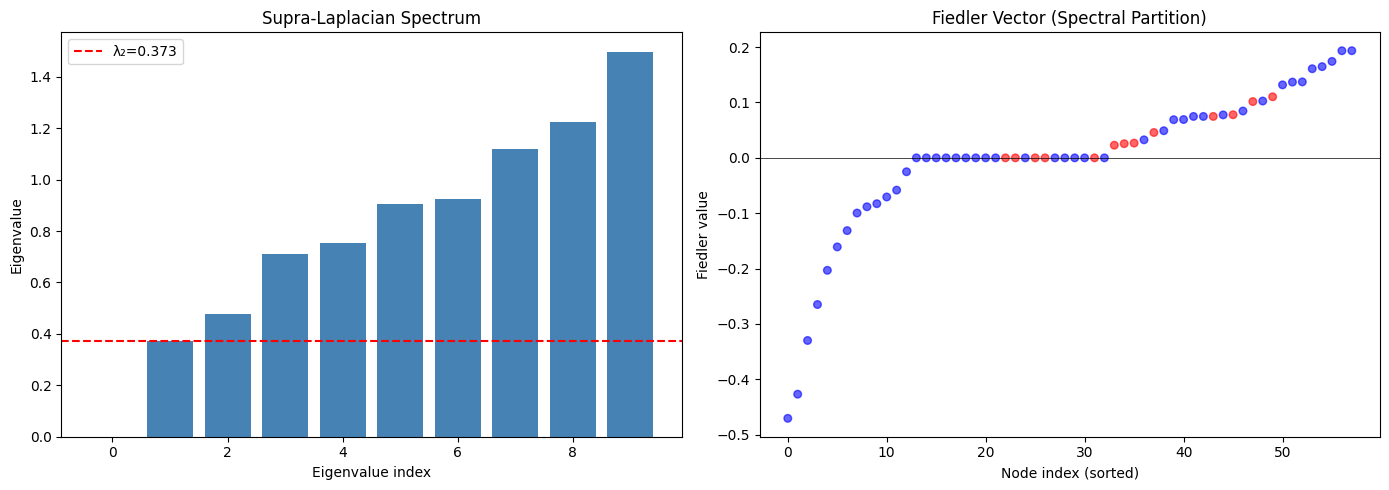

In [28]:
# . Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvalue spectrum
# Axes indexing changes from axes[0, 0] to axes[0]
ax = axes[0]
ax.bar(range(len(eigenvalues)), eigenvalues, color='steelblue')
ax.axhline(y=eigenvalues[1], color='red', linestyle='--', label=f'λ₂={eigenvalues[1]:.3f}')
ax.set_xlabel('Eigenvalue index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Supra-Laplacian Spectrum')
ax.legend()

# Plot 2: Fiedler vector
# Axes indexing changes from axes[0, 1] to axes[1]
ax = axes[1]
colors = ['red' if f < 0 else 'blue' for f in fiedler_vec]
ax.scatter(range(len(fiedler_vec)), np.sort(fiedler_vec), c=colors, alpha=0.6, s=30)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Node index (sorted)')
ax.set_ylabel('Fiedler value')
ax.set_title('Fiedler Vector (Spectral Partition)')

# 3. Remove Plot 3 and Plot 4 code entirely

plt.tight_layout()
plt.show()

In [29]:
# . Cytoscape layer visualization

from annnet.adapters import cx2_adapter as cx
import json

G.create_slice_from_layer("ppi_layer", ("PPI",), include_inter=False, include_coupling=False)
ppi_subgraph = G.subgraph_from_slice("ppi_layer")

In [30]:
sbuc = cx.to_cx2(ppi_subgraph)

output_file = "sbuc.cx2"

"""with open(output_file, "w") as f:
    json.dump(sbuc, f)

print(f"Saved to {output_file}")"""

AttributeError: 'NoneType' object has no attribute 'DataFrame'

In [31]:
# . SBML import and Cytoscape


from annnet.adapters import SBML_adapter as sb

# From SBML
gg = sb.from_sbml("Haridansyah2019.sbml")


#To cx2 (Cytoscape exchange 2)
#H2 = cx.to_cx2(gg, hyperedges= "expand")
output_file = "Haridansyah2019.cx2"

"""with open(output_file, "w") as f:
    json.dump(H2, f)

print(f"Saved to {output_file}")"""

'with open(output_file, "w") as f:\n    json.dump(H2, f)\n\nprint(f"Saved to {output_file}")'

In [43]:
print(gg.V,"\n", gg.E)

('B_pb', 'CARTE_pb', 'IL6', 'IL10', 'IFNg', 'CARTE_t', 'CARTM_pb', 'CARTM_t', '__BOUNDARY_SOURCE__', '__BOUNDARY_SINK__') 
 ('B_pb_exponential_growth_rate', 'B_pb_decay', 'CARTE_pb_injection', 'CARTE_pb_self_growth', 'CARTE_pb_decay', 'CARTE_pb_conversion_CARTE_t', 'CARTE_pb_converion_CARTM_pb', 'CARTM_pb_converion_CARTE_pb', 'B_pb_killing_CARTE', 'IL6_const_production', 'IL6_induced_production_CARTE_pb', 'IL6_decay', 'IL10_const_production', 'IL10_induced_production_CARTE_pb', 'IL10_decay', 'IFNg_const_production', 'IFNg_induced_production_CARTE_pb', 'IFNg_decay', 'CARTM_pb_self_growth', 'CARTM_pb_decay', 'CARTM_pb_conversion_CARTM_t')


In [37]:
# . Lossless write/read as .annnet:

#G.write("SBUC.annnet", overwrite=True)

In [38]:
#G2 = Graph.read("SBUC.annnet")

In [39]:
assert G2.V == G.V
assert G2.E == G.E
print("Lossless roundtrip Ok")

NameError: name 'G2' is not defined